# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [3]:
%load_ext autoreload

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [6]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [82]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [83]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

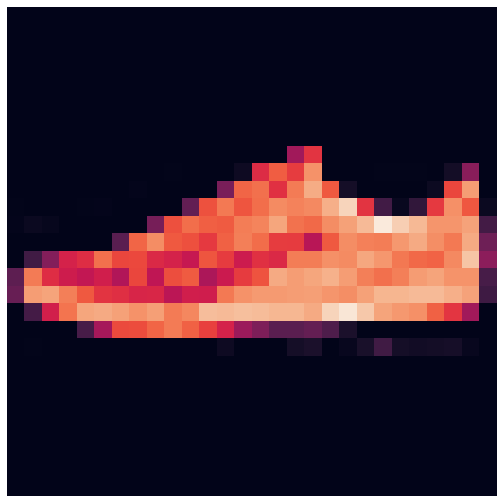

In [84]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

Задание сделано нелогично, я знаю. Надо было через соответствие лейблам в "у" их вытаскивать. Тут у меня по-тупому вручную, но мне жалко переделывать, так что пусть будет. Пожалуйста, не снимайте полбалла(((

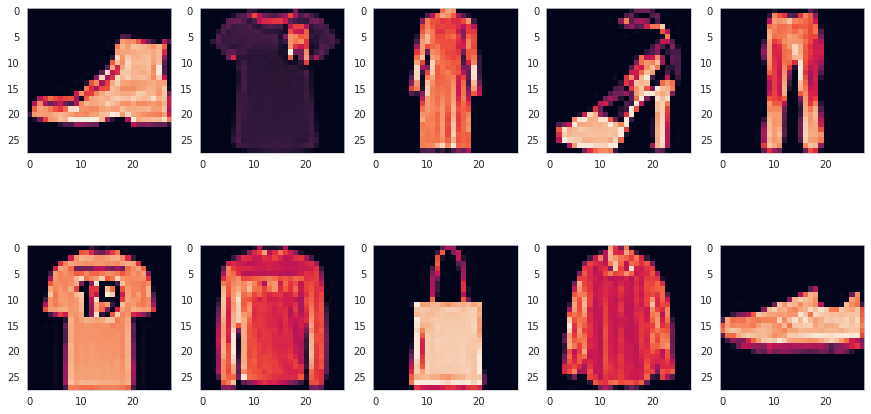

'\n0 \tT-shirt/top\n1 \tTrouser\n2 \tPullover\n3 \tDress\n4 \tCoat\n5 \tSandal\n6 \tShirt\n7 \tSneaker\n8 \tBag\n9 \tAnkle boot\n'

In [85]:
plt.rcParams['axes.grid'] = False
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,8))

axs[0,0].imshow(X[1].reshape(28, 28)) #9
axs[0,1].imshow(X[2].reshape(28, 28)) #6
axs[0,2].imshow(X[3].reshape(28, 28)) #3
axs[0,3].imshow(X[4].reshape(28, 28)) #5
axs[0,4].imshow(X[5].reshape(28, 28)) #1

axs[1,0].imshow(X[27].reshape(28, 28)) #0
axs[1,1].imshow(X[12].reshape(28, 28)) #2
axs[1,2].imshow(X[14].reshape(28, 28)) #8
axs[1,3].imshow(X[18].reshape(28, 28)) #4
axs[1,4].imshow(X[22].reshape(28, 28)) #7
plt.show()

'''
0 	T-shirt/top
1 	Trouser
2 	Pullover
3 	Dress
4 	Coat
5 	Sandal
6 	Shirt
7 	Sneaker
8 	Bag
9 	Ankle boot
'''

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

In [86]:
len(X) #Xlength

1000

In [12]:
len(y) #y length

1000

In [13]:
#dir(X) - all the attributes, we can get information from them

In [14]:
# Just playing around, idk if it can be called EDA
print(X.data) #where is it stored
print(X.size)
print(X.shape) #1000 pics each of c this
print(X.itemsize) # size of each symbol, I guess (8 bites)
X[1][400:500] #each picture looks like this

784000
(1000, 784)
8


array([  2.,   7.,   0.,  24., 162., 191., 102., 151., 214., 236., 210.,
       207., 202., 205., 206., 210., 214., 206., 207.,   0.,   0.,   2.,
         2.,   0.,   1.,   2.,   5.,   1.,   0.,   0.,   0., 182., 141.,
       107., 158., 164., 227., 215., 196., 196., 195., 204., 209., 218.,
       215., 203., 231.,  11.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   6., 128., 196., 148., 150., 191., 210., 226., 222., 218.,
       212., 211., 215., 235., 232., 218., 218., 200., 230.,  75.,   0.,
         3., 118., 147., 178., 160., 146., 158., 164., 101.,  11., 168.,
       207., 214., 221., 215., 229., 237., 230., 227., 237., 228., 221.,
       226.])

In [15]:
print(np.var(X) == np.nanvar(X)) #there are no NaN's

True


In [16]:
np.unique(y) #there are 9 classes

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

#### Соотношение классов

In [17]:
for i in range(9):
  print(f'class{i} =', y[y == str(i)].size)

class0 = 93
class1 = 102
class2 = 95
class3 = 121
class4 = 96
class5 = 98
class6 = 101
class7 = 79
class8 = 109


### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=300, train_size=700, random_state=SEED, shuffle=True, stratify=None)

In [19]:
print(
    X_test.shape,
    X_train.shape,
    y_test.shape,
    y_train.shape
    )

(300, 784) (700, 784) (300,) (700,)


### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [88]:
binary_test_X = X_test[y_test == '0']
binary_test_X = np.append(binary_test_X, X_test[y_test == '1'], axis=0)

binary_train_X = X_train[y_train == '0']
binary_train_X = np.append(binary_train_X, X_train[y_train == '1'], axis=0)

binary_test_y = y_test[y_test == '0']
binary_test_y = np.append(binary_test_y, y_test[y_test == '1'])

binary_train_y = y_train[y_train == '0']
binary_train_y = np.append(binary_train_y, y_train[y_train == '1'])

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [89]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [91]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [92]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [93]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [25]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

75.9 ms ± 9.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.3 ms ± 516 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
42.4 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [94]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

In [95]:
print(prediction)

['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '1' '0' '0' '0' '0' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1']


### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [28]:
# TODO: binary_classification_metrics in metrics.py

In [96]:
print(binary_classification_metrics(binary_test_y, prediction))

(0.9714285714285714, 1.0, 0.9855072463768115, 0.9841269841269841)


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [97]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [100]:
print(
    precision_score(binary_test_y, prediction, pos_label='1'), 
    recall_score(binary_test_y, prediction, pos_label='1'), 
    f1_score(binary_test_y, prediction, pos_label='1'), 
    accuracy_score(binary_test_y, prediction)
)

0.9714285714285714 1.0 0.9855072463768115 0.9841269841269841


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [107]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    train_metrics = []
    test_metrics = []
    for k in params:
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)
        y_pred_test = knn_classifier.predict(X_test)
        y_pred_train = knn_classifier.predict(X_train)
        test_metrics.append(metric(y_test, y_pred_test))
        train_metrics.append(metric(y_train, y_pred_train))
        print(f"With k = {k} train metric = {metric(y_train, y_pred_train)}")
        print(f"With k = {k} test metric = {metric(y_test, y_pred_test)}")
        print()
    return train_metrics, test_metrics
    pass

In [108]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

With k = 1 train metric = 1.0
With k = 1 test metric = 0.9841269841269841

With k = 2 train metric = 1.0
With k = 2 test metric = 1.0

With k = 4 train metric = 0.9848484848484849
With k = 4 test metric = 1.0

With k = 5 train metric = 0.9772727272727273
With k = 5 test metric = 1.0

With k = 8 train metric = 0.9772727272727273
With k = 8 test metric = 1.0

With k = 10 train metric = 0.9772727272727273
With k = 10 test metric = 1.0

With k = 30 train metric = 0.9318181818181818
With k = 30 test metric = 0.9841269841269841



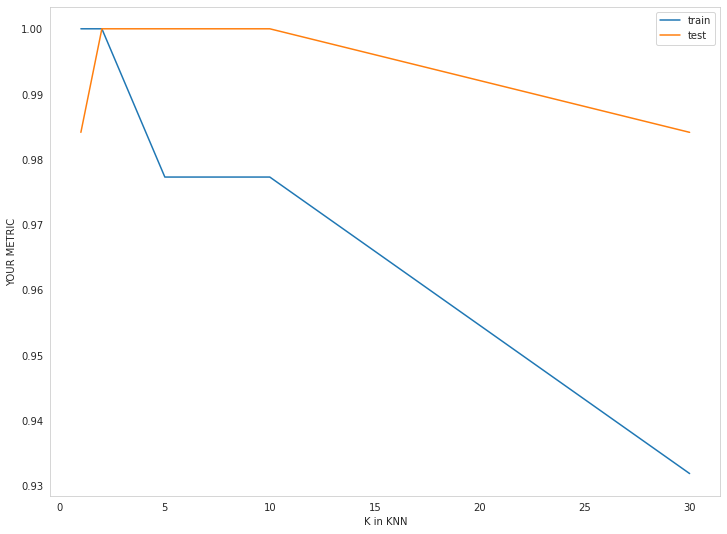

In [103]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

Кажется, 2-10 подходит

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [104]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [105]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

0.76

In [106]:
print(multiclass_accuracy(predictions, y_test))
print(accuracy_score(predictions, y_test))

0.76
0.76


Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [109]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, accuracy_score)

With k = 1 train metric = 1.0
With k = 1 test metric = 0.76

With k = 2 train metric = 0.8957142857142857
With k = 2 test metric = 0.7433333333333333

With k = 4 train metric = 0.8457142857142858
With k = 4 test metric = 0.77

With k = 5 train metric = 0.8342857142857143
With k = 5 test metric = 0.7733333333333333

With k = 8 train metric = 0.8028571428571428
With k = 8 test metric = 0.7766666666666666

With k = 10 train metric = 0.8085714285714286
With k = 10 test metric = 0.78

With k = 30 train metric = 0.7414285714285714
With k = 30 test metric = 0.7



## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [3]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [4]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
X.info()
X.mean()
X.std()
X.max()
X.min()

In [5]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times the square root of n_samples (i.e. the sum of squares of each column totals 1).
(From documetation) --> data is already standartisized

Column 11 is a quantitative measure of disease progression one year after baseline. Ее вроде бы нет необходимости стандартизовывать. Ну типа зачем, если мы можем в любой шкале сделать предсказание

In [48]:
#isnull() returns True for both None and NaN values
X.isnull().sum() #only 0
y.isnull().sum() # 0

0

In [ ]:
y.head()

In [ ]:
len(y)

In [11]:
print(f'std_y = {y.std()}, mean = {y.mean()}, min = {y.min()}, max = {y.max()}')

std_y = 77.09300453299109, mean = 152.13348416289594, min = 25.0, max = 346.0


Данные уже стандартизированы по-своему, но их можно привести в привычный вид

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [87]:
import numpy as np

class KNeighborsRegressor:
    def __init__(self, k=5):
        self.k = k
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        y_pred = []
        n_train = self.X_train.shape[0]
        n_test = X.shape[0]
        distances = np.zeros((n_test, n_train), dtype=np.float32)
        for i in range(X.shape[0]):
            for j in range(self.X_train.shape[0]):
                distances[i, j] = (X.iloc[[i]]-self.X_train.iloc[[j]]).abs().sum()
        num_dist = distances.shape[0]
        for i in range(num_dist):
            y_indicies = np.argsort(distances[i, :], axis=0)
            closest_y = self.y_train[y_indicies[:self.k]]
            k_nearest = distances[:self.k]
            y_pred.append(np.mean([x[1] for x in k_nearest]))
        return np.array(y_pred)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=SEED, 
                                                    test_size=0.1)

In [76]:
from sklearn.neighbors import KNeighborsRegressor

In [88]:
knn_regressor = KNeighborsRegressor()
knn_regressor.fit(X_train, y_train)

In [32]:
X_test.shape

(45, 10)

In [78]:
y_pred = knn_regressor.predict(X_test)

### Теперь можно сравнить, насколько похожие цифры у нас получились:

In [67]:
y_pred_dataframe = pd.DataFrame(y_pred)
y_pred_dataframe.describe()

,0
count,45.000000
mean,145.751111
std,48.408605
min,59.200000
25%,114.400000
50%,136.200000
75%,183.200000
max,240.400000


In [66]:
y_test.describe()

count     45.000000
mean     159.377778
std       63.195328
min       59.000000
25%       97.000000
50%      163.000000
75%      208.000000
max      302.000000
Name: target, dtype: float64

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [2]:
from metrics import r_squared, mse, mae

In [89]:
r_squared(y_pred, y_test)

0.1414319147596197

In [90]:
mse(y_pred, y_test)

3352.624

In [91]:
mae(y_pred, y_test)

43.66222222222222

#### Сравним с метриками из sklearn

In [79]:
r2_score(y_test, y_pred)

0.1414319147596197

In [80]:
mean_squared_error(y_test, y_pred)

3352.624

In [81]:
mean_absolute_error(y_test, y_pred)

43.66222222222222

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [73]:
from metrics import r_squared, mse, mae

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

Моя find_best_k здесь не подходит, но я ее немного модифицирую и использую

In [79]:
def find_best_k_r(X_train, y_train, X_test, y_test, params, metric):
    
    train_metrics = []
    test_metrics = []
    for k in params:
        knn_regressor = KNeighborsRegressor(k)
        knn_regressor.fit(X_train, y_train)
        y_pred_test = knn_regressor.predict(X_test)
        y_pred_train = knn_regressor.predict(X_train)
        test_metrics.append(metric(y_test, y_pred_test))
        train_metrics.append(metric(y_train, y_pred_train))
        print(f"With k = {k} train metric = {metric(y_train, y_pred_train)}")
        print(f"With k = {k} test metric = {metric(y_test, y_pred_test)}")
        print()
    return train_metrics, test_metrics
    pass

In [80]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k_r(X_train, y_train, X_test, y_test, params, r_squared)
#best --> 1000000
#best k 2-5

With k = 1 train metric = 1.0
With k = 1 test metric = 0.09716865776491612

With k = 2 train metric = 0.6636082049256271
With k = 2 test metric = -0.1105122637804361

With k = 4 train metric = 0.2818362539948127
With k = 4 test metric = -0.34787379410214836

With k = 5 train metric = 0.23954001837062766
With k = 5 test metric = -0.46318606619561553

With k = 8 train metric = 0.0742462968088462
With k = 8 test metric = -0.670417179930267

With k = 10 train metric = -0.028005363599235666
With k = 10 test metric = -0.8031484990735696

With k = 30 train metric = -0.5406724256597977
With k = 30 test metric = -1.3167462987709344



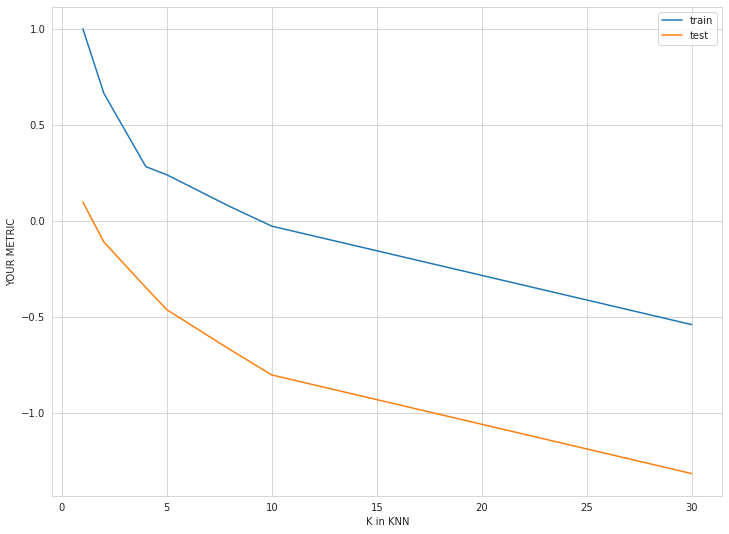

In [81]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

In [83]:
train_metrics, test_metrics = find_best_k_r(X_train, y_train, X_test, y_test, params, mse)
#best --> 0
#best k 2-8

With k = 1 train metric = 0.0
With k = 1 test metric = 5103.9111111111115

With k = 2 train metric = 1549.5245591939547
With k = 2 test metric = 3648.6722222222224

With k = 4 train metric = 2392.8107682619648
With k = 4 test metric = 3515.1805555555557

With k = 5 train metric = 2437.6912846347604
With k = 5 test metric = 3352.624

With k = 8 train metric = 2676.149126259446
With k = 8 test metric = 3181.2166666666667

With k = 10 train metric = 2792.04040302267
With k = 10 test metric = 2988.944222222222

With k = 30 train metric = 3075.0123929471033
With k = 30 test metric = 2790.7216049382723



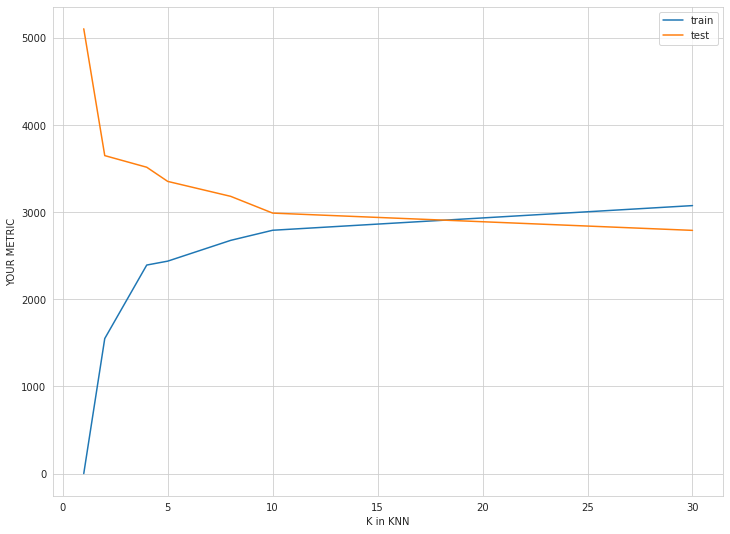

In [84]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

In [85]:
train_metrics, test_metrics = find_best_k_r(X_train, y_train, X_test, y_test, params, mae)
#best --> 0
#best k 4-8

With k = 1 train metric = 0.0
With k = 1 test metric = 57.955555555555556

With k = 2 train metric = 29.749370277078086
With k = 2 test metric = 48.12222222222222

With k = 4 train metric = 38.0919395465995
With k = 4 test metric = 44.67777777777778

With k = 5 train metric = 38.531989924433255
With k = 5 test metric = 43.66222222222222

With k = 8 train metric = 40.8397355163728
With k = 8 test metric = 43.96666666666667

With k = 10 train metric = 41.80453400503779
With k = 10 test metric = 41.553333333333335

With k = 30 train metric = 45.263140218303946
With k = 30 test metric = 42.30296296296296



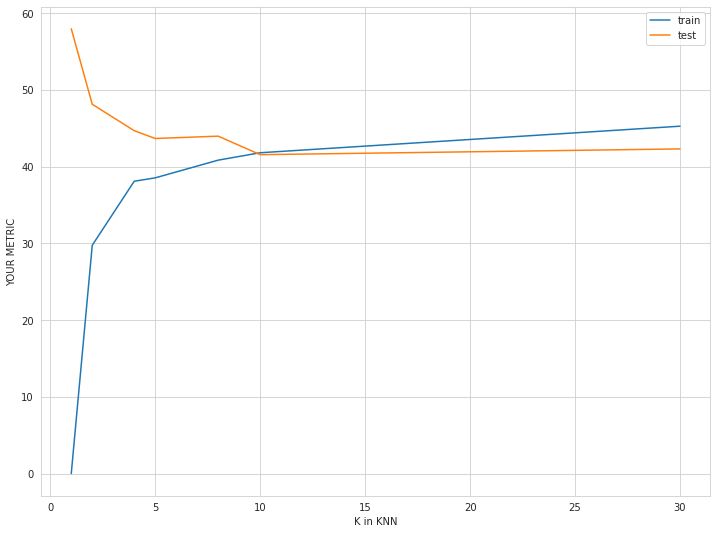

In [86]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("YOUR METRIC");

Best k = 10 (or smth like that idunno...)

Если делать стандартизацию у, наверное, оценивать будет легче((

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

## Therapy time

Оч сложно, особенно, если ты забыл pandas и numpy напрочь... 
Заняло у меня полные две недели и несколько часов на поплакать. Мб это я хлебушек конечно, вроде некоторые справились быстрее, но хотелось бы чуть больше подсказок. 

Мои ашибки:
1. надо сначала полностью читать блокнот, наперед знать, что потом потребуется
2. социализацию делать надо было, как мы поняли, даже полбалла по мл на дороге не валяется
